Just set up a new system in SLab on BFG, running TKID (baseband) AMC card.  Checking if the system is working by checking loopback response.

# Import useful python libraries

In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import yaml
import time
import pickle as pkl
import os
import sys
import numpy as np
from matplotlib import cm
from scipy.signal import butter, welch, filtfilt, periodogram, savgol_filter
import pandas as pd
import glob
from scipy.optimize import curve_fit
import scipy.linalg as linalg

Configure matplotlib plotting 

In [2]:
plt.ion()
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, facecolor='white') 

# Initialize a pysmurf control instance

In [3]:
import pysmurf.client
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import epics
import os
import time

%matplotlib inline

epics_prefix = "smurf_server_s4"
config_file  = "/usr/local/src/pysmurf/cfg_files/slab/experiment_b33_C03-A03-06_bfg_squats.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix, cfg_file=config_file, setup=False, make_logfile=True)

The first time you power up the system, you have to run `S.setup()`.  But if you start up using the `shawnhammer` command on the command line, it runs it for you before handing you a control terminal.

# Dump versions of everything for posterity

In [4]:
# Python version
print (sys.version)
import pysmurf
pysmurf.__version__
cwd=os.getcwd()
os.chdir('/usr/local/src/pysmurf/')
#print(str(!git branch))
#print(!git rev-parse --short HEAD)
epics_prefix=f'smurf_server_s{S.slot_number}'
print(S._caget(f'{epics_prefix}:AMCc:RogueVersion', as_string=True))
print(S._caget(f'{epics_prefix}:AMCc:SmurfApplication:SmurfVersion', as_string=True))
print(S._caget(f'{epics_prefix}:AMCc:SmurfApplication:StartupArguments', as_string=True))
print(S.get_fpga_git_hash_short())
print(S.config.filename)

3.8.10 (default, Mar 13 2023, 10:26:41) 
[GCC 9.4.0]
v4.11.10
7.4.0
-w smurf_server_s4 -e smurf_server_s4 -l 2 -a 10.0.1.104 -z /tmp/fw/rogue_CryoDetKid_v2.0.0.zip --disable-bay1 -d /tmp/fw/smurf_cfg/defaults/defaults_c03_tkid_none.yml --enable-em22xx
e3253bd
/usr/local/src/pysmurf/cfg_files/slab/experiment_b33_C03-A03-06_bfg_squats.cfg


In [5]:
S.log_file

'/data/smurf_data/20240924/1727200548/outputs/1727200548.log'

In [6]:
S.log("first log!")

In [7]:
!cat /usr/local/src/pysmurf/cfg_files/b33/experiment_b33_lbOnlyBay0_c04-02.cfg

{
"epics_root" : "test_epics",
"init": {

	"dspEnable": 1,

	"band_0" : {
		"iq_swap_in" : 0,
		"iq_swap_out" : 0,
		# Measured for 8234f45 by SWH on 8/1/19
		"refPhaseDelay" : 6,
		"refPhaseDelayFine" : 16,
		"trigRstDly" : 15, # 0xF
		"feedbackEnable": 1,
		"feedbackGain" : 256,
		"feedbackPolarity" : 1,
		"feedbackLimitkHz": 225,
		"lmsGain": 5,
		"att_uc": 24,
		"att_dc": 0,
		"amplitude_scale": 12
	},

	"band_1" : {
		"iq_swap_in" : 0,
		"iq_swap_out" : 0,
		# Measured for 8234f45 by SWH on 8/1/19
		"refPhaseDelay" : 6,
		"refPhaseDelayFine" : 19,
		"trigRstDly" : 15, # 0xF
		"feedbackEnable": 1,
		"feedbackGain" : 256,
		"feedbackPolarity" : 1,
		"feedbackLimitkHz": 225,
		"lmsGain": 5,
		"att_uc": 24,
		"att_dc": 0,
		"amplitude_scale": 12
	},

	"band_2" : {
		"iq_swap_in" : 0,
		"iq_swap_out" : 0,
		# Measured for bdc4981 by SWH on 7/17/20
		"refPhaseDelay" : 6,
		"refPhaseDelayFine" : 19,
		"trigRstDly" : 15, # 0xF
		"feedbackEnable": 1,
		"feedbackGain" : 256,
		"feedbackPola

In [8]:
os.getcwd()

'/usr/local/src/pysmurf'

## Streaming Demo in fridge:

# Tell SMuRF what band center frequency is

I'll set them for baseband configuration but if you use a mixer you can adjust to include LO so that all the frequencies you're working with are the true ones into the cryostat.

In [26]:
S.set_band_center_mhz(band,595.2)
S.set_band_center_mhz(band,4750)
S.set_band_center_mhz(band,5250)
S.set_band_center_mhz(band,5750)

# Let's check the loopback response

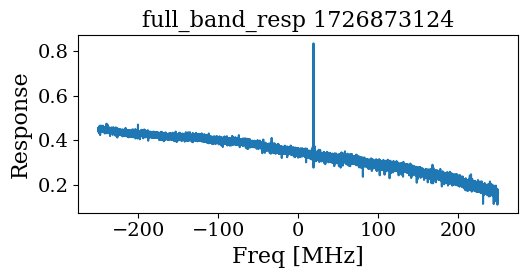

(array([-3.07200000e+08, -3.07197656e+08, -3.07195312e+08, ...,
         3.07192969e+08,  3.07195312e+08,  3.07197656e+08]),
 array([-0.00793207-0.37695783j, -0.01284159-0.38148744j,
        -0.01626997-0.38302373j, ...,  0.0030999 -0.38765888j,
         0.00489311-0.38353529j, -0.00920449-0.37336882j]))

In [23]:
S.full_band_resp(0,make_plot=True,show_plot=True)

In [15]:
?S.find_freq

Signature:
S.find_freq(
    band,
    start_freq=-250,
    stop_freq=250,
    subband=None,
    tone_power=None,
    n_read=2,
    make_plot=False,
    save_plot=True,
    plotname_append='',
    window=50,
    rolling_med=True,
    make_subband_plot=False,
    show_plot=False,
    grad_cut=0.05,
    flip_phase=False,
    grad_kernel_width=8,
    amp_cut=0.25,
    pad=2,
    min_gap=2,
)
Docstring:
Finds the resonances in a band (and specified subbands)

Args
----
band : int
    The band to search.
start_freq : float, optional, default -250
    The scan start frequency in MHz (from band center)
stop_freq : float, optional, default 250
    The scan stop frequency in MHz (from band center)
subband : deprecated, use start_freq/stop_freq.
    numpy.ndarray of int or None, optional, default None
    An int array for the subbands.  If None, set to all
    processed subbands =numpy.arange(13,115).
    Takes precedent over start_freq/stop_freq.
tone_power : int or None, optional, default None


# Estimating and correcting for the phase delay

-------------------------------------------------------
Estimated cable_delay_us=0.662049477535204
Estimated dsp_delay_us=8.817711403655883
Estimated processing_delay_us=8.155661926120679
-------------------------------------------------------


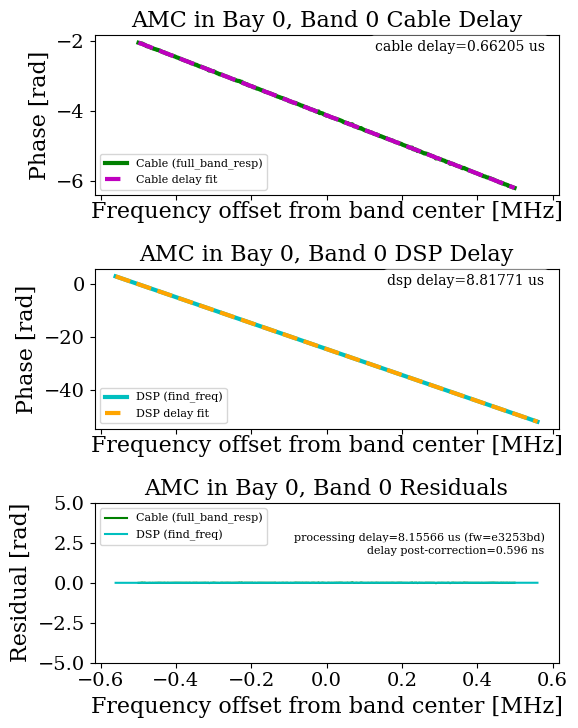

(8.817711403655883, 0.0005956589736848361)

In [24]:
S.estimate_phase_delay(0,freq_min=-0.5e6,freq_max=0.5e6)

# Setting a fixed tone

SMuRF is optimized for a tone power of 12 (digital units), so we almost always use 12 here.  The max is 15 (0-15).  

In [27]:
S.set_fixed_tone(562.4,12)

(0, 335)

Before this will work, you have to set the band center to the hardware value of 595.2.  Right now, you can only do that for one band (which is all you need) or the `set_fixed_tone` routine will get confused and not know which band to assign the tone to.

Ok to read RF ADC do this

/usr/local/src/pysmurf/python/pysmurf/client/util/smurf_util.py:1630: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(plot_fn)


array([ 334.-331.j,  214.-434.j,   56.-484.j, ..., -125.-456.j,
       -285.-370.j, -398.-270.j])

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


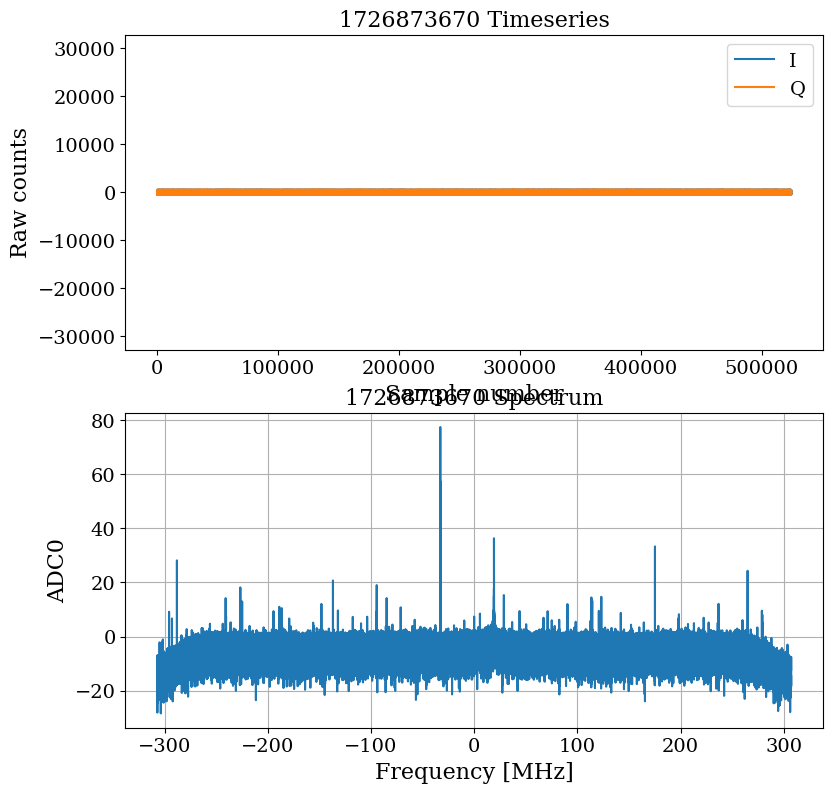

In [29]:
S.read_adc_data(0,make_plot=True,show_plot=True)

Ok, so there's a tone there at about the right place.

In [30]:
print(562.4-595.2)

-32.80000000000007


If you want, you can check if the ADC is saturated.

In [31]:
S.check_adc_saturation(0)

False

Right now, there should be a 562.4 MHz signal coming out of the band 0 output.  Next step is to confirm that it is and check its power level.

# How to see what tones are on / turn tones off

To see what bands have channels on, can do


In [32]:
for band in S._bands:
    print(f'{band} : {S.which_on(band)}')

0 : [335]
1 : []
2 : []
3 : []


To get the frequency of a channel you can do

In [36]:
S.channel_to_freq(band=0,channel=335)

562.3999999523163

To turn off one channel;

In [37]:
S.channel_off(band=0,channel=335)

To turn off all channels in a band

In [38]:
S.band_off(0)

# Doing a high s/n frequency sweep

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


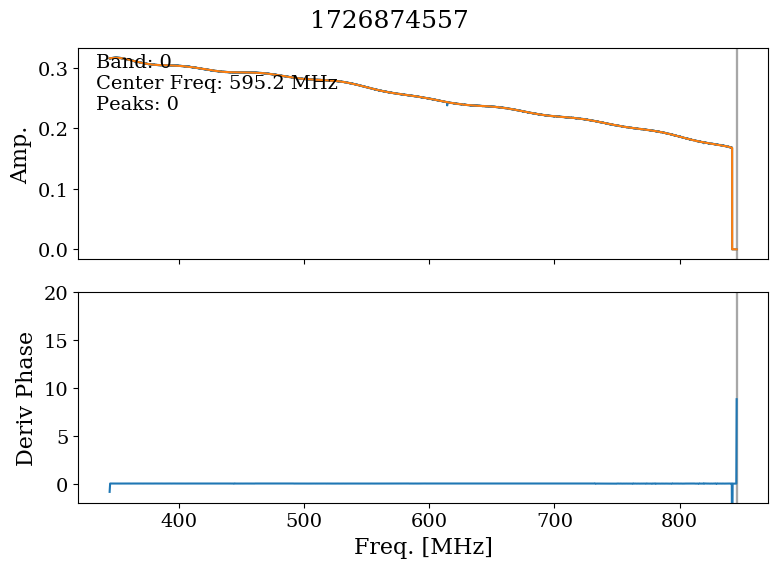

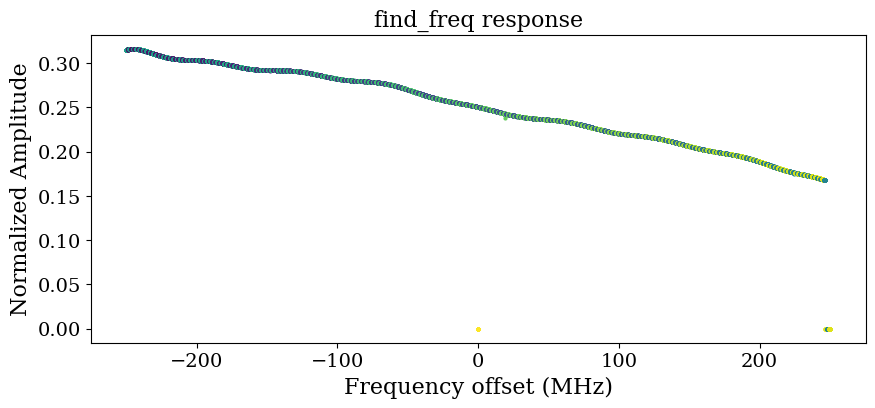

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [41]:
S.find_freq(0,make_plot=True,show_plot=True)

In [ ]:
S.setup_notches(